In [4]:
import jax
import jax.numpy as jnp
from sklearn.linear_model import LogisticRegression
import os
import pickle
from variational.exponential_family import GenericMeanFieldNormalDistribution, NormalDistribution, MeanFieldNormalDistribution
from experiments.logisticRegression.mnist.load_mnist import mnist_dataset
import matplotlib.pyplot as plt

OUTPUT_PATH = "./output_mean_field/"
OP_key = jax.random.PRNGKey(0)
logreg = LogisticRegression(penalty=None, fit_intercept=False)
jax.config.update("jax_enable_x64", True)
mnist_train, mnist_test = mnist_dataset(return_test=True, flip=False)
flipped_predictors, response = mnist_train
flipped_predictors_test, response_test = mnist_test
N, dim = flipped_predictors.shape

In [5]:
PKLs = []
PKL_titles = []
for file in os.listdir(OUTPUT_PATH):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(OUTPUT_PATH + "/"+ file, "rb")))
        PKL_titles.append(str(file))

full_gaussian = GenericMeanFieldNormalDistribution(dimension=dim)

In [5]:
logreg.fit(flipped_predictors, response)
test_prediction = logreg.predict(flipped_predictors_test)
jnp.sum(test_prediction != response_test) / len(response_test)

Array(0.01074719, dtype=float64)

In [6]:
from sklearn.metrics import log_loss

log_loss(response_test, logreg.predict_proba(flipped_predictors_test))
log_loss(response, logreg.predict_proba(flipped_predictors))

0.0010100226273692804

In [7]:
def missclassification_over_test(betas):
    u = (flipped_predictors_test@betas.T).T
    classification = jax.vmap(lambda x: (x<0)*(-1.) + (x>0)*1.)(u)
    rates = jnp.mean(classification != response_test, axis=-1)
    return rates

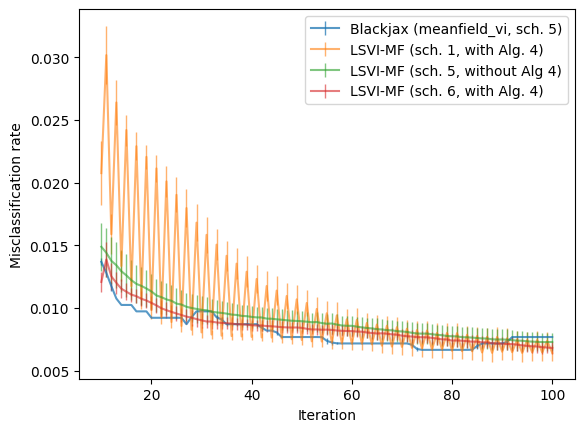

In [20]:
labels = ["LSVI-MF (sch. 5, without Alg 4)", "LSVI-MF (sch. 1, with Alg. 4)", "Blackjax (meanfield_vi, sch. 5)", "LSVI-MF (sch. 6, with Alg. 4)"]

start = 10
end = 100+1


idx=2
my_means = PKLs[idx]['states'][0]
shape = my_means.shape
my_means = my_means.reshape((-1, dim))
rates = missclassification_over_test(my_means).reshape(shape[:-1]).T
plt.errorbar(x=range(start, end), y=rates[start:end].mean(axis=-1), yerr=rates[start:end].std(axis=-1),
             label=labels[idx],
            elinewidth=1., alpha=0.75)

for idx in [1, 0, 3]:
    """
    Computing the mean of the regression coefficients, for each repetitions, iterations
    Computing the rates of missclasification
    """
    my_etas = PKLs[idx]['res'][..., :-1]
    d = my_etas.shape[-1]
    shape = my_etas.shape
    my_etas = my_etas.reshape((-1, d))
    my_mean_betas = jax.vmap(full_gaussian.get_mean_cov)(my_etas)[0]
    rates = missclassification_over_test(my_mean_betas)
    rates = rates.reshape(shape[:-1]).T
    plt.errorbar(x=range(start, end), y=rates[start:end].mean(axis=-1), yerr=rates[start:end].std(axis=-1), 
                 label=labels[idx], 
                elinewidth=1., alpha=0.6)

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Misclassification rate")
plt.savefig("MNIST_missclassification_rate_mean_std_over_100_it.pdf")

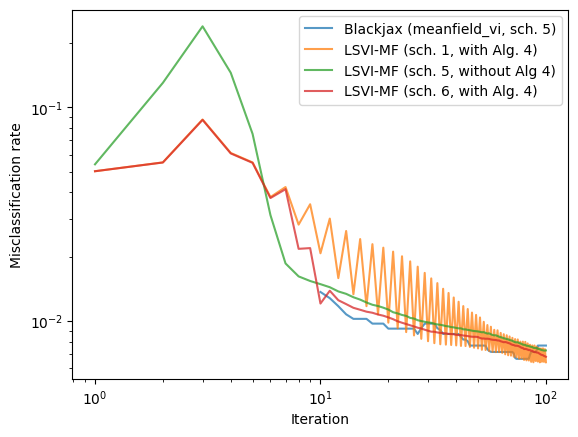

In [21]:

idx=2
my_means = PKLs[idx]['states'][0]
shape = my_means.shape
my_means = my_means.reshape((-1, dim))
rates = missclassification_over_test(my_means).reshape(shape[:-1]).T
plt.loglog(range(start, end), rates[start:end].mean(axis=-1),
             label=labels[idx], alpha=0.75)

for idx in [1, 0, 3]:
    """
    Computing the mean of the regression coefficients, for each repetitions, iterations
    Computing the rates of missclasification
    """
    my_etas = PKLs[idx]['res'][..., :-1]
    d = my_etas.shape[-1]
    shape = my_etas.shape
    my_etas = my_etas.reshape((-1, d))
    my_mean_betas = jax.vmap(full_gaussian.get_mean_cov)(my_etas)[0]
    rates = missclassification_over_test(my_mean_betas)
    rates = rates.reshape(shape[:-1]).T
    start = 1
    end = 100+1
    plt.loglog(range(start, end), rates[start:end].mean(axis=-1),  
                 label=labels[idx], alpha=0.75)

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Misclassification rate")
plt.savefig("log_MNIST_missclassification_rate_mean_std_over_100_it.pdf")